# Import libraries

In [1]:
import sys
from pathlib import Path
sys.path.insert(0,'..')
import glob
#!pip install openpyxl

In [13]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
import re

from functools import partial
from multiprocessing import Pool

from lhcsmapi.Time import Time
from lhcsmapi.Timer import Timer
from lhcsmapi.metadata.MappingMetadata import MappingMetadata
from scipy import signal
import xarray as xr

from src.utils.utils import log_acquisition
from src.utils.hdf_tools import acquisition_to_hdf5, load_from_hdf_with_regex
from src.visualisation.sec_quench_visualisation import plot_wiggle_analysis
from src.modeling.sec_quench import *
from src.utils.dataset_utils import *
from src.utils.utils import interp

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')
#%matplotlib widget
#%matplotlib inline
#%load_ext autoreload

# Define Paths

In [3]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')
data_path = file_path / '20220707_data'
simulation_path = file_path / '20220707_simulation'

# Read the (clean) MP3 file

In [4]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
len(mp3_fpa_df)

3981

# Select events to analyze

In [5]:
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['timestamp_fgc', 'Circuit Name'])
lower_limit = Time.to_unix_timestamp('2014-01-01 00:00:00+01:00')
mp3_fpa_df_period = mp3_fpa_df_unique[mp3_fpa_df_unique['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 

mp3_fpa_df_period_all = mp3_fpa_df[mp3_fpa_df['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 
print(len(mp3_fpa_df_period), len(mp3_fpa_df_period_all))

822 3981


In [6]:
# Add information, whether download was successfull
df_acquisition = pd.read_excel("../data/20220707_acquisition_summary.xlsx")
mp3_fpa_df_period_merged = mp3_fpa_df_period.merge(df_acquisition , left_on=['Circuit Name', 'timestamp_fgc'], right_on=['Circuit Name', 'timestamp_fgc'], how="left")
df_to_analyze = mp3_fpa_df_period_merged[mp3_fpa_df_period_merged['VoltageNQPS.*U_DIODE']==1]
len(df_to_analyze)

563

In [7]:
for c in df_acquisition.columns:
    available = len(df_acquisition[df_acquisition[c]==1])
    print(f"Available events {c}: {available}")

Available events Circuit Name: 0
Available events timestamp_fgc: 0
Available events date_fgc: 0
Available events I_MEAS: 896
Available events VoltageNQPS.*U_DIODE: 629
Available events VoltageNXCALS.*U_DIODE: 867
Available events I_EARTH_PCNT: 895
Available events IEARTH.I_EARTH: 629
Available events U_QS0: 893
Available events U_1: 893
Available events U_2: 893
Available events I_HDS: 896
Available events U_HDS: 896
Available events EEUDumpResPM: 896
Available events simulation_data: 875
Available events nominal_data: 863


# Analyze all events

In [8]:
%matplotlib inline

In [21]:
fpa_identifier = "RB_RB.A45_1620109620660000000" # "RB_RB.A45_1620109620660000000"  #"RB_RB.A78_1617170255140000000"      
circuit_name = fpa_identifier.split("_")[1]
timestamp_fgc = int(fpa_identifier.split("_")[2])

mp3_fpa_df_subset = mp3_fpa_df[(mp3_fpa_df.timestamp_fgc == timestamp_fgc) & 
                               (mp3_fpa_df['Circuit Name'] == circuit_name)]
all_quenched_magnets = mp3_fpa_df_subset.Position.values
quench_times = mp3_fpa_df_subset["Delta_t(iQPS-PIC)"].values /1e3
        
# load data pm
data_dir = data_path / (fpa_identifier + ".hdf5")
data_pm = load_from_hdf_with_regex(file_path=data_dir, regex_list=['VoltageNQPS.*U_DIODE'])
df_data_pm = u_diode_data_to_df(data_pm, len_data=len(data_pm[0]))

# load data nxcals
data_nxcals = load_from_hdf_with_regex(file_path=data_dir, regex_list=["VoltageNXCALS.*U_DIODE"])
df_data_nxcals = u_diode_data_to_df(data_nxcals, len_data=len(data_nxcals[0]))

# load simulation
simulation_dir = simulation_path / (fpa_identifier + ".hdf")
data_sim = load_from_hdf_with_regex(file_path=simulation_dir, regex_list=["0v_magf"])
df_sim = u_diode_simulation_to_df(data_sim, circuit_name=circuit_name)

# save magnet order for later usage
magnet_list = df_sim.columns

# drop quenched magnet for alignment
max_time = df_data_pm.index.max()#np.inf
df_data_pm_noq = drop_quenched_magnets(df_data_pm, all_quenched_magnets, quench_times, max_time)
#df_data_nxcals_noq = drop_quenched_magnets(df_data_nxcals, all_quenched_magnets, quench_times, max_time)
df_sim_noq = drop_quenched_magnets(df_sim, all_quenched_magnets, quench_times, max_time)

# sometimes only noise is stored, mean must be in window -1, -10
mean_range = [-1.5, -10]
drop_columns = df_data_pm_noq.columns[~(mean_range[0] > df_data_pm_noq.mean()) | 
                                      (mean_range[1] > df_data_pm_noq.mean())]
df_data_pm_noq = df_data_pm_noq.drop(drop_columns, axis=1)
df_data_nxcals = df_data_nxcals.drop(drop_columns, axis=1)

# align with simulation data
# align with energy extraction timestamp
ee_margins = [-0.25, 0.25] # first ee must be within this interval
t_first_extraction = get_u_diode_data_alignment_timestamps(df_sim_noq, ee_margins=ee_margins) # also integer from mp3 excel can be used
df_data_pm_aligned = align_u_diode_data(df_data=df_data_pm_noq.copy(),
                                     t_first_extraction=t_first_extraction,
                                     ee_margins=ee_margins)

# add quenched magnets
dropped_quench = df_data_pm.loc[:,~df_data_pm.columns.isin(df_data_pm_noq.columns.values)].columns.values
df_data_pm_aligned.loc[:,dropped_quench] = df_data_pm[dropped_quench]

# cut out time frame to analyze, samples are used instead of intervall to ensure equal len in all events
# 1763 samples is intervall [-0.25, 1.4]
time_frame_pm = [-0.25, 1.4]
n_samples_pm = 1763
df_data_pm_cut = get_df_time_window(df=df_data_pm_aligned, timestamp=0, time_frame=time_frame_pm, n_samples=n_samples_pm)
time_frame_nxcals = [time_frame_pm[1], np.inf]
n_samples_nxcals = 4900
df_data_nxcals_cut = get_df_time_window(df=df_data_nxcals, timestamp=0, time_frame=time_frame_nxcals, n_samples=n_samples_nxcals)

df_data_cut = pd.concat([df_data_pm_cut, df_data_nxcals_cut.dropna()])

# adjust simulation length to data
df_sim_resampled = interp(df_sim, df_data_cut.index)


# add dropped magnets again for continuity
dropped_columns_data = magnet_list[~magnet_list.isin(df_data_cut.columns)]
dropped_columns_simulation = magnet_list[~magnet_list.isin(df_sim_resampled.columns)]
df_data_cut[dropped_columns_data] = np.nan
df_sim_resampled[dropped_columns_simulation] = np.nan
# bring into electrical order again
df_data_cut = df_data_cut[magnet_list]
df_sim_resampled = df_sim_resampled[magnet_list]


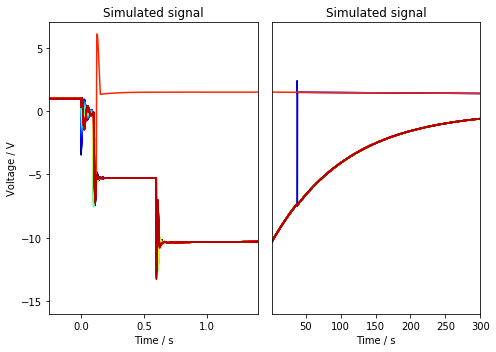

In [44]:
fig, ax = plt.subplots(1,2, figsize=(7,5))
cmap = mpl.cm.jet(np.linspace(0,0.95,154))

for i, m in enumerate(magnet_list):
    df_sim_resampled[m].plot(legend=False, ax=ax[0], c=cmap[i], lw=1.5)
    df_sim_resampled[m].plot(legend=False, ax=ax[1], c=cmap[i], lw=1.5)

ax[0].set_xlabel('Time / s')
ax[0].set_ylabel('Voltage / V')

ax[1].set_yticks([])
ax[1].set_xlabel('Time / s')

ax[0].set_xlim((-0.25,1.4))
ax[1].set_xlim((1.4,300))

ax[0].set_ylim((-16,7))
ax[1].set_ylim((-16,7))

ax[0].set_title('Simulated signal')
ax[1].set_title('Simulated signal')


plt.tight_layout()
#plt.show()
plt.savefig('udiode_sim.png', dpi=300)

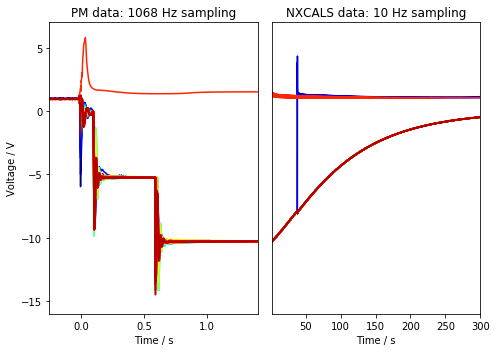

In [42]:
fig, ax = plt.subplots(1,2, figsize=(7,5))
cmap = mpl.cm.jet(np.linspace(0,0.95,154))

for i, m in enumerate(magnet_list):
    df_data_pm_cut[m].plot(legend=False, ax=ax[0], c=cmap[i])
    df_data_nxcals_cut[m].plot(legend=False, ax=ax[1], c=cmap[i])

ax[0].set_xlabel('Time / s')
ax[0].set_ylabel('Voltage / V')

ax[1].set_yticks([])
ax[1].set_xlabel('Time / s')

ax[0].set_xlim((-0.25,1.4))
ax[1].set_xlim((1.4,300))

ax[0].set_ylim((-16,7))
ax[1].set_ylim((-16,7))

ax[0].set_title('PM data: 1068 Hz sampling')
ax[1].set_title('NXCALS data: 10 Hz sampling')


plt.tight_layout()
#plt.show()
plt.savefig('udiode.png', dpi=300)

In [ ]:
i =1
for c in df_data_aligned.columns:
    fig, ax = plt.subplots(figsize = (15,10))
    df_data_cut[c].plot(ax=ax, label="data_aligned")
    #df_data_noq[c].plot(ax=ax, label="data")
    #df_data_aligned
    df_sim_noq_resampled[c].plot(ax=ax, label="simulation")
    plt.title(f"{i,c}")
    plt.legend()
    
    ee_odd = float(mp3_fpa_df_subset['Delta_t(EE_odd-PIC)'].values[0]) / 1000
    ee_even = float(mp3_fpa_df_subset['Delta_t(EE_even-PIC)'].values[0]) / 1000
    plt.axvline(x=ee_odd)
    plt.axvline(x=ee_even)

    i+=1
    if i > 20:
        break

# Get all events

In [60]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


from src.dataset import load_dataset
from src.datasets.rb_fpa_prim_quench import RBFPAPrimQuench
from src.datasets.rb_fpa_prim_quench_ee_plateau import RBFPAPrimQuenchEEPlateau
from src.datasets.rb_fpa_sec_quench import RBFPASecQuench

/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details a

In [ ]:
dataset_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_full_dataset")
plot_dataset_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_prim_ee_plateau_plots")
context_path = Path("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
acquisition_summary_path = Path("../data/20220707_acquisition_summary.xlsx")
data_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_data")
simulation_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_simulation")


# load dataset
dataset = load_dataset(creator=RBFPAPrimQuenchEEPlateau,
                       dataset_path=dataset_path,
                       context_path=context_path,
                       acquisition_summary_path=acquisition_summary_path,
                       data_path=data_path,
                       simulation_path=simulation_path,
                       plot_dataset_path=plot_dataset_path,
                       generate_dataset=False)

In [ ]:
mp3_fpa_df_in_dataset = mp3_fpa_df_period[mp3_fpa_df_period.fpa_identifier.isin(dataset.event.values)]
mp3_fpa_df_in_dataset["first_exrtraction"] = [min(float(row['Delta_t(EE_odd-PIC)']) / 1000, float(row['Delta_t(EE_even-PIC)']) / 1000) for i, row in mp3_fpa_df_in_dataset.iterrows()]

# Split dataset